In [1]:
# -*- coding: utf-8 -*-

## Map Generalization for Polygons using Autoencode-like strucutures
## 
## Author: Yu Feng, yuzz.feng@gmail.com
## 1. Version Author: SERCAN CAKIR - Adatped based on Master Thesis of SERCAN CAKIR "ROAD NETWORK EXTRACTION USING CNN"

## Changes:
## 1. Two conv layers were added before the first down convlusional layer
## 2. Output can be any size during the evaluation
## 3. Adapt the code to support more images as training examples
## 4. Dropouot may make the sharpe corners vanishing, we delete half of them, but we should used some
## 5. Splilt step for generate training and validation data
## 6. Prepare to update in github

import matplotlib
#matplotlib.use('Agg') # necessary for linux kernal
%matplotlib inline
import matplotlib.pyplot as plt

import os
import numpy as np
from numpy import random
np.random.seed(7)
import itertools

import keras
from keras import backend as K

from keras.models import Model, Sequential
#from keras.layers.core import Dropout
from keras.layers import Input, Conv2D, Dropout, UpSampling2D, Activation, Concatenate, Add
from keras.layers import MaxPooling2D, Conv2DTranspose, BatchNormalization, Activation

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, History

from osgeo import gdal
from sklearn.model_selection import train_test_split
from skimage.util.shape import view_as_windows

from data_helper import readImg, readImgInv, imagePatches, removeBlackImg, removeCorrespondence, check_and_create

from time import gmtime, strftime
timestr = strftime("%Y-%m-%d %H-%M-%S", gmtime())

scale = 15 #25

############ Path Setting ##############
outPath = r"../tmp_results/predictions/"
outPath = outPath + timestr + '_' + str(scale)+ "/"
check_and_create(outPath)

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Prepare Training Data

In [2]:
# Order the image dimension acc. to TensorFlow (batc_hsize, rows, cols, channels)
K.set_image_dim_ordering('tf')

p_size_1 = 128 # Compared with 256, which larger may generate round corners
trainPath = r"../tmp_data/data_feng/geb" + str(scale) +  "/"

# save image patch arrays
x_train_sim = np.load(trainPath + "x_train_sim.npy")
y_train_sim = np.load(trainPath + "y_train_sim.npy")
x_test_sim = np.load(trainPath + "x_test_sim.npy")
y_test_sim = np.load(trainPath + "y_test_sim.npy")

Input Shape of the models (32289, 128, 128, 1)


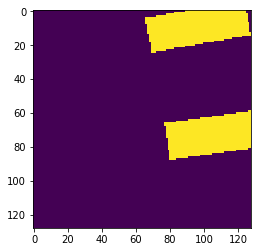

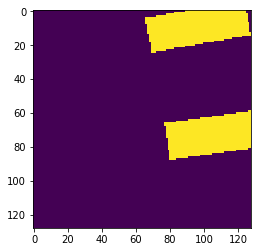

In [3]:
plt.figure()
plt.imshow(np.reshape(x_test_sim[2], (p_size_1,p_size_1)))
plt.figure()
plt.imshow(np.reshape(y_test_sim[2], (p_size_1,p_size_1)))

input_shape1 = (None, None, 1) #x_train_sim[0].shape
print('Input Shape of the models', x_train_sim.shape)

In [4]:
import numpy as np
import os

from keras.optimizers import Adam
from pix2pix.utils.facades_generator import facades_generator
from pix2pix.networks.generator import UNETGenerator
from pix2pix.networks.discriminator import PatchGanDiscriminator
from pix2pix.networks.DCGAN import DCGAN
from pix2pix.utils import patch_utils
from pix2pix.utils import logger
import time

from keras.utils import generic_utils as keras_generic_utils

def num_patches(output_img_dim=(3, 256, 256), sub_patch_dim=(64, 64)):
    """
    Creates non-overlaping patches to feed to the PATCH GAN
    (Section 2.2.2 in paper)
    The paper provides 3 options.
    Pixel GAN = 1x1 patches (aka each pixel)
    PatchGAN = nxn patches (non-overlaping blocks of the image)
    ImageGAN = im_size x im_size (full image)

    Ex: 4x4 image with patch_size of 2 means 4 non-overlaping patches

    :param output_img_dim:
    :param sub_patch_dim:
    :return:
    """
    # num of non-overlaping patches
    nb_non_overlaping_patches = (output_img_dim[0] / sub_patch_dim[0]) * (output_img_dim[1] / sub_patch_dim[1])

    # dimensions for the patch discriminator
    patch_disc_img_dim = (sub_patch_dim[0], sub_patch_dim[1], output_img_dim[2])

    return int(nb_non_overlaping_patches), patch_disc_img_dim

# ---------------------------------------------
# HYPER PARAMS
# ---------------------------------------------
# width, height of images to work with. Assumes images are square
im_width = im_height = 128

# inpu/oputputt channels in image
input_channels = 1
output_channels = 1

# image dims
input_img_dim = (im_width, im_height, input_channels)
output_img_dim = (im_width, im_height, output_channels)

# We're using PatchGAN setup, so we need the num of non-overlaping patches
# this is how big we'll make the patches for the discriminator
# for example. We can break up a 256x256 image in 16 patches of 64x64 each
sub_patch_dim = (32, 32)
nb_patch_patches, patch_gan_dim = num_patches(output_img_dim=output_img_dim, sub_patch_dim=sub_patch_dim)
print(output_img_dim, nb_patch_patches, patch_gan_dim)

(128, 128, 1) 16 (32, 32, 1)


In [5]:
# ---------------------------------------------
# TRAINING ROUTINE
# ---------------------------------------------

# ----------------------
# GENERATOR
# Our generator is an AutoEncoder with U-NET skip connections
# ----------------------
generator_nn = UNETGenerator(input_img_dim=input_img_dim, num_output_channels=output_channels)
generator_nn.summary()

# ----------------------
# PATCH GAN DISCRIMINATOR
# the patch gan averages loss across sub patches of the image
# it's fancier than the standard gan but produces sharper results
# ----------------------
discriminator_nn = PatchGanDiscriminator(output_img_dim=output_img_dim,
        patch_dim=patch_gan_dim, nb_patches=nb_patch_patches)
discriminator_nn.summary()

# disable training while we put it through the GAN
discriminator_nn.trainable = False

# ------------------------
# Define Optimizers
opt_discriminator = Adam(lr=1E-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
opt_dcgan = Adam(lr=1E-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

# -------------------------
# compile generator
generator_nn.compile(loss='mae', optimizer=opt_discriminator)

# ----------------------
# MAKE FULL DCGAN
# ----------------------
dc_gan_nn = DCGAN(generator_model=generator_nn,
                  discriminator_model=discriminator_nn,
                  input_img_dim=input_img_dim,
                  patch_dim=sub_patch_dim)

dc_gan_nn.summary()

# ---------------------
# Compile DCGAN
# we use a combination of mae and bin_crossentropy
loss = ['mae', 'binary_crossentropy']
loss_weights = [1E2, 1]
dc_gan_nn.compile(loss=loss, loss_weights=loss_weights, optimizer=opt_dcgan)

# ---------------------
# ENABLE DISCRIMINATOR AND COMPILE
discriminator_nn.trainable = True
discriminator_nn.compile(loss='binary_crossentropy', optimizer=opt_discriminator)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
unet_input (InputLayer)         (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 64)   1088        unet_input[0][0]                 
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 64, 64, 64)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 32, 128)  131200      leaky_re_lu_1[0][0]              
__________________________________________________________________________________________________
gen_en_bn_

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
DCGAN_input (InputLayer)        (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
unet_generator (Model)          (None, 128, 128, 1)  24267969    DCGAN_input[0][0]                
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 128, 128, 1)  0           unet_generator[1][0]             
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 128, 128, 1)  0           unet_generator[1][0]             
__________________________________________________________________________________________________
lambda_4 (

In [ ]:
# ------------------------
# RUN ACTUAL TRAINING
batch_size = 1
nb_epoch = 100
n_images_per_epoch = 400

print('Training starting...')
for epoch in range(0, nb_epoch):

    print('Epoch {}'.format(epoch))
    batch_counter = 1
    start = time.time()
    progbar = keras_generic_utils.Progbar(n_images_per_epoch)

    

    # go through 1... n_images_per_epoch (which will go through all buckets as well
    for mini_batch_i in range(0, n_images_per_epoch, batch_size):

        # load a batch of decoded and original images
        # both for training and validation
        X_train_decoded_imgs, X_train_original_imgs = next(tng_gen)
        X_val_decoded_imgs, X_val_original_imgs = next(val_gen)

        # generate a batch of data and feed to the discriminator
        # some images that come out of here are real and some are fake
        # X is image patches for each image in the batch
        # Y is a 1x2 vector for each image. (means fake or not)
        X_discriminator, y_discriminator = patch_utils.get_disc_batch(X_train_original_imgs,
                                                          X_train_decoded_imgs,
                                                          generator_nn,
                                                          batch_counter,
                                                          patch_dim=sub_patch_dim)

        # Update the discriminator
        # print('calculating discriminator loss')
        disc_loss = discriminator_nn.train_on_batch(X_discriminator, y_discriminator)

        # create a batch to feed the generator
        X_gen_target, X_gen = next(patch_utils.gen_batch(X_train_original_imgs, X_train_decoded_imgs, batch_size))
        y_gen = np.zeros((X_gen.shape[0], 2), dtype=np.uint8)
        y_gen[:, 1] = 1

        # Freeze the discriminator
        discriminator_nn.trainable = False

        # trainining GAN
        # print('calculating GAN loss...')
        gen_loss = dc_gan_nn.train_on_batch(X_gen, [X_gen_target, y_gen])

        # Unfreeze the discriminator
        discriminator_nn.trainable = True

        # counts batches we've ran through for generating fake vs real images
        batch_counter += 1

        # print losses
        D_log_loss = disc_loss
        gen_total_loss = gen_loss[0].tolist()
        gen_total_loss = min(gen_total_loss, 1000000)
        gen_mae = gen_loss[1].tolist()
        gen_mae = min(gen_mae, 1000000)
        gen_log_loss = gen_loss[2].tolist()
        gen_log_loss = min(gen_log_loss, 1000000)

        progbar.add(batch_size, values=[("Dis logloss", D_log_loss),
                                        ("Gen total", gen_total_loss),
                                        ("Gen L1 (mae)", gen_mae),
                                        ("Gen logloss", gen_log_loss)])

        # ---------------------------
        # Save images for visualization every 2nd batch
        if batch_counter % 2 == 0:

            # print images for training data progress
            logger.plot_generated_batch(X_train_original_imgs, X_train_decoded_imgs, generator_nn, epoch, 'tng', mini_batch_i)

            # print images for validation data
            X_full_val_batch, X_sketch_val_batch = next(patch_utils.gen_batch(X_val_original_imgs, X_val_decoded_imgs, batch_size))
            logger.plot_generated_batch(X_full_val_batch, X_sketch_val_batch, generator_nn, epoch, 'val', mini_batch_i)

    # -----------------------
    # log epoch
    print("")
    print('Epoch %s/%s, Time: %s' % (epoch + 1, nb_epoch, time.time() - start))

    # ------------------------------
    # save weights on every 2nd epoch
    if epoch % 2 == 0:
        gen_weights_path = os.path.join('./pix2pix_out/weights/gen_weights_epoch_%s.h5' % (epoch))
        generator_nn.save_weights(gen_weights_path, overwrite=True)

        disc_weights_path = os.path.join('./pix2pix_out/weights/disc_weights_epoch_%s.h5' % (epoch))
        discriminator_nn.save_weights(disc_weights_path, overwrite=True)

        DCGAN_weights_path = os.path.join('./pix2pix_out/weights/DCGAN_weights_epoch_%s.h5' % (epoch))
        dc_gan_nn.save_weights(DCGAN_weights_path, overwrite=True)


In [ ]:
from keras.layers import Input, Lambda
from keras.models import Model

from keras import models
from keras.optimizers import Adam

tmpPath = "../tmp_results/predictions/2018-11-30 11-10-35_15_residual_unet/"
generator_model = models.load_model(tmpPath + "weights.hdf5")
                


## Training

## Independent Test